In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("UsedCarPricePrediction").getOrCreate()
sc = spark.sparkContext

# Reading csv file in pyspark dataframe:
df = spark.read.csv(r"C:\Users\Ajinkya\Desktop\Project\vehicles.csv",header=True, inferSchema=True)

df.printSchema()
df.count()

#Drop the independent columns :
columns_to_delete = ['id', 'url', 'region_url','VIN','image_url','description','county','lat','long','posting_date','size','state']
df1 = df.drop(*columns_to_delete)

# Show column after deleting:
df1.columns

#drop duplicated records :
df2 = df1.distinct()
df2.count()

#Calculate the percentage of null values for each column :
null_counts = df2.select([sum(col(column).isNull().cast('int')).alias(column) for column in df2.columns])
total_rows = df2.count()
null_percentages = null_counts.select([((col(column) / total_rows) * 100).alias(column + "_null_percentage") for column in df2.columns])
null_percentages.show() # show null value %

#Drop rows with null values in specified columns :
df3 = df2.na.drop(subset=['region','price','year','model','odometer','manufacturer','transmission','title_status','fuel'])
df3.count()

#Handling Missing Values with Categorical Encoding :
df4 = df3.fillna('unknown')

#handling cloumns :

#manufacturer :
# Define the list of top 20 manufacturers
manufacturer_values = ['nissan','honda','chevrolet','mercedes-benz','ram','dodge','ford','jeep','toyota','bmw','subaru','volkswagen','kia','cadillac','hyundai','lexus','audi','chrysler','acura','buick']

# Use when function to update the 'manufacturer' column
df5 = df4.withColumn('manufacturer', 
                   when(df4['manufacturer'].isin(manufacturer_values), df4['manufacturer'])
                   .otherwise('others'))

# region :
# Count the occurrences of each region value
manufacturer_counts = df5.groupBy('region').count()

# Sort the counts in descending order and select the top 50 region
top_manufacturers = manufacturer_counts.orderBy('count', ascending=False).limit(50)

# Extract the top 50 region values
manufacturer_values = [row['region'] for row in top_manufacturers.collect()]

# Use when function to update the 'region' column
df6 = df5.withColumn('region', 
                     when(df5['region'].isin(manufacturer_values), df5['region'])
                     .otherwise('others'))

#model :
# Count the occurrences of each model value
manufacturer_counts = df6.groupBy('model').count()

# Sort the counts in descending order and select the top 50 model
top_manufacturers = manufacturer_counts.orderBy('count', ascending=False).limit(50)

# Extract the top 50 model values
manufacturer_values = [row['model'] for row in top_manufacturers.collect()]

# Use when function to update the 'model' column
df7 = df6.withColumn('model',
                     when(df6['model'].isin(manufacturer_values), df6['model'])
                     .otherwise('others'))


# transmission :
names_to_match = ['automatic','manual','other','unknown'] 
df8 = df7.filter((col("transmission").isin(names_to_match)) )

#year :
#converting year, odometer, price column type to integer type:

df9 = df8.withColumn("year", col('year').cast("int"))
df10 = df9.withColumn("odometer", col('odometer').cast("int"))
df11 = df10.withColumn("price", col('price').cast("int"))
#df11.printSchema()

# handling outliers :
#price:
# Calculate quartiles

price_percentiles = df11.approxQuantile("price", [0.15, 0.75], 0.01)
price_percentile15 = price_percentiles[0]
price_percentile75 = price_percentiles[1]

# Calculate IQR and upper/lower limits

price_iqr = price_percentile75 - price_percentile15
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = price_percentile15

# Filter DataFrame based on limits
df12 = df11.filter((col("price") < price_upper_limit) & (col("price") > price_lower_limit))


#odometer:
# Calculate percentiles
odometer_percentiles = df12.approxQuantile("odometer", [0.05, 0.25, 0.75], 0.01)
odometer_percentile05 = odometer_percentiles[0]
odometer_percentile25 = odometer_percentiles[1]
odometer_percentile75 = odometer_percentiles[2]

# Calculate IQR and upper/lower limits
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = odometer_percentile05

# Filter DataFrame based on limits
df13 = df12.filter((col("odometer") < odometer_upper_limit) & (col("odometer") > odometer_lower_limit))

#year : removing year before 1996 based on barplot distribution :
# Filter DataFrame based on the condition
df14 = df13.where(df13['year'] > 1996)

# Drop records where year column has a value of 2022
df15 = df14.filter(df['year'] != 2022)

# adding new column 'car_age' based on purchase year and till 2022
df16 = df15.withColumn('car_age', 2024 - col('year'))

#droping year :
df17 = df16.drop('year')
df17.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nu

In [2]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Define numerical and categorical columns
numerical_cols = ["odometer", "car_age"]
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 
                    'transmission', 'drive', 'type', 'paint_color', 'region']

# Define stages for the Pipeline
stages = []

# Numerical feature vector assembler
numerical_vector_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_feature_vector')
stages.append(numerical_vector_assembler)

# Standard scaling for numerical features
scaler = StandardScaler(inputCol='numerical_feature_vector', outputCol='scaled_numerical_feature_vector',
                        withStd=True, withMean=True)
stages.append(scaler)

# String indexing for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+'_index', handleInvalid="keep") for col in categorical_cols]
stages.extend(indexers)

# One-hot encoding for indexed categorical columns
one_hot_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+'_encoded')
                    for indexer in indexers]
stages.extend(one_hot_encoders)

# Assemble all features into a single vector column
feature_cols = ['scaled_numerical_feature_vector'] + [indexer.getOutputCol()+'_encoded' for indexer in indexers]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='final_feature_vector')
stages.append(assembler)

# Create the Pipeline
pipeline = Pipeline(stages=stages)

# Fit the Pipeline on the data
pipeline_model = pipeline.fit(df17)

# Transform the data
df_transformed = pipeline_model.transform(df17)

# Split the transformed data into train and test sets
train, test = df_transformed.randomSplit([0.8, 0.2], seed=23)

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,StandardScaler
from pyspark.ml.regression import LinearRegression,RandomForestRegressor,DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder

In [4]:
lr = LinearRegression(featuresCol='final_feature_vector',labelCol='price')
lr=lr.fit(train)


train_predictions = lr.transform(test)

# Step 8: Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_li = evaluator.evaluate(train_predictions)
mse_li = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
mae_li = evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
rmse_li = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})

# Print the evaluation metrics
print("R2 on test data = %g" % r2_li)
print("Mean squared error:", mse_li)
print("Mean absolute error:", mae_li)
print("Root mean squared error:", rmse_li)

# Show predictions
train_predictions.select("final_feature_vector", "price", "prediction").show()


R2 on test data = 0.743116
Mean squared error: 38948822.382577576
Mean absolute error: 4640.350445010096
Root mean squared error: 6240.899164589793
+--------------------+-----+------------------+
|final_feature_vector|price|        prediction|
+--------------------+-----+------------------+
|(186,[0,1,3,23,76...| 3900|  6108.90705281599|
|(186,[0,1,3,23,74...| 4500|112.30122178760212|
|(186,[0,1,6,23,75...| 4750|-7905.007627918676|
|(186,[0,1,16,23,7...| 4900|1440.0850312952134|
|(186,[0,1,2,28,74...| 5991|-171.4573183559114|
|(186,[0,1,19,23,7...| 6500|  9519.87114372883|
|(186,[0,1,6,31,75...| 6500| 12724.29484137168|
|(186,[0,1,2,23,76...| 7200| 15326.06861479904|
|(186,[0,1,5,23,76...| 7500| -5820.47636434036|
|(186,[0,1,6,23,76...| 8200|12847.421794492986|
|(186,[0,1,10,23,7...| 8499| 9910.185377344402|
|(186,[0,1,3,23,76...| 9500|12604.677636939836|
|(186,[0,1,3,23,76...| 9988|16891.539477302784|
|(186,[0,1,6,23,76...|11000|15118.939771978135|
|(186,[0,1,5,39,76...|12900| 20290.8

In [5]:
rf = RandomForestRegressor(featuresCol='final_feature_vector',labelCol='price')
rf = rf.fit(train)

train_predictions = rf.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Evaluate the model
r2_rf= evaluator.evaluate(train_predictions)
mse_rf= evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
mae_rf= evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
rmse_rf= evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})

# Print the evaluation metrics
print("R2 on test data = %g" % r2_rf)
print("Mean squared error:", mse_rf)
print("Mean absolute error:", mae_rf)
print("Root mean squared error:", rmse_rf)

# Show predictions
train_predictions.select("final_feature_vector", "price", "prediction").show()

R2 on test data = 0.683677
Mean squared error: 47960853.098949365
Mean absolute error: 5232.554849899256
Root mean squared error: 6925.377469780934
+--------------------+-----+------------------+
|final_feature_vector|price|        prediction|
+--------------------+-----+------------------+
|(186,[0,1,3,23,76...| 3900|10522.630849708654|
|(186,[0,1,3,23,74...| 4500|10373.312397558115|
|(186,[0,1,6,23,75...| 4750| 8410.902996485598|
|(186,[0,1,16,23,7...| 4900| 9762.409397843885|
|(186,[0,1,2,28,74...| 5991|10143.723728411267|
|(186,[0,1,19,23,7...| 6500| 8819.745310996146|
|(186,[0,1,6,31,75...| 6500| 9967.788183444127|
|(186,[0,1,2,23,76...| 7200|19117.275594595973|
|(186,[0,1,5,23,76...| 7500|10085.168503955745|
|(186,[0,1,6,23,76...| 8200|17704.869579880404|
|(186,[0,1,10,23,7...| 8499|10218.707938463827|
|(186,[0,1,3,23,76...| 9500| 20124.12501097375|
|(186,[0,1,3,23,76...| 9988|11687.881712851393|
|(186,[0,1,6,23,76...|11000|13238.430336264355|
|(186,[0,1,5,39,76...|12900|19585.05

In [6]:
# Define Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol='final_feature_vector',
                      labelCol='price')

# Train the model
dt = dt.fit(train)

# Make predictions
train_predictions = dt.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_dt= evaluator.evaluate(train_predictions)
mse_dt= evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
mae_dt= evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
rmse_dt= evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})

# Print the evaluation metrics
print("R2 on test data = %g" % r2_dt)
print("Mean squared error:", mse_dt)
print("Mean absolute error:", mae_dt)
print("Root mean squared error:", rmse_dt)

# Show predictions
train_predictions.select("final_feature_vector", "price", "prediction").show()

R2 on test data = 0.651585
Mean squared error: 52826700.72819911
Mean absolute error: 5384.209073195944
Root mean squared error: 7268.197901006763
+--------------------+-----+------------------+
|final_feature_vector|price|        prediction|
+--------------------+-----+------------------+
|(186,[0,1,3,23,76...| 3900|11016.463738207547|
|(186,[0,1,3,23,74...| 4500|11016.463738207547|
|(186,[0,1,6,23,75...| 4750|   7809.8957419832|
|(186,[0,1,16,23,7...| 4900|   7809.8957419832|
|(186,[0,1,2,28,74...| 5991|12534.092065466264|
|(186,[0,1,19,23,7...| 6500|11016.463738207547|
|(186,[0,1,6,31,75...| 6500|   7809.8957419832|
|(186,[0,1,2,23,76...| 7200| 21403.92765273312|
|(186,[0,1,5,23,76...| 7500|   7809.8957419832|
|(186,[0,1,6,23,76...| 8200|15833.909735908554|
|(186,[0,1,10,23,7...| 8499|   7809.8957419832|
|(186,[0,1,3,23,76...| 9500|19476.474479166667|
|(186,[0,1,3,23,76...| 9988|11016.463738207547|
|(186,[0,1,6,23,76...|11000| 11471.15808297568|
|(186,[0,1,5,39,76...|12900| 23070.21

In [7]:
# Define Ridge Regression model
ridge = LinearRegression(featuresCol="final_feature_vector", labelCol="price", elasticNetParam=0.0, regParam=0.5) # regParam is the regularization parameter for Ridge Regression

# Train the model
ridge_model = ridge.fit(train)

# Make predictions
train_predictions = ridge_model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_ri= evaluator.evaluate(train_predictions)
mse_ri= evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
mae_ri= evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
rmse_ri= evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
print("R2 on test data = %g" % r2_ri)
print("Mean squared error:", mse_ri)
print("Mean absolute error:", mae_ri)
print("Root mean squared error:", rmse_ri)
# Show predictions
train_predictions.select("final_feature_vector", "price", "prediction").show()

R2 on test data = 0.743116
Mean squared error: 38948809.745570034
Mean absolute error: 4640.338939907379
Root mean squared error: 6240.898152154867
+--------------------+-----+-------------------+
|final_feature_vector|price|         prediction|
+--------------------+-----+-------------------+
|(186,[0,1,3,23,76...| 3900|    6109.2652109801|
|(186,[0,1,3,23,74...| 4500| 112.87396984665611|
|(186,[0,1,6,23,75...| 4750| -7904.114396573146|
|(186,[0,1,16,23,7...| 4900|  1440.716095300053|
|(186,[0,1,2,28,74...| 5991|-171.09320751462292|
|(186,[0,1,19,23,7...| 6500|  9519.996705273654|
|(186,[0,1,6,31,75...| 6500|  12724.17636775713|
|(186,[0,1,2,23,76...| 7200| 15326.391892858153|
|(186,[0,1,5,23,76...| 7500| -5819.570609177259|
|(186,[0,1,6,23,76...| 8200| 12847.224991155996|
|(186,[0,1,10,23,7...| 8499|   9910.53497191073|
|(186,[0,1,3,23,76...| 9500|  12604.76843654762|
|(186,[0,1,3,23,76...| 9988| 16891.541002382124|
|(186,[0,1,6,23,76...|11000| 15118.846256434212|
|(186,[0,1,5,39,76.

In [8]:
# Define Ridge Regression model
lasso = LinearRegression(featuresCol="final_feature_vector", labelCol="price", elasticNetParam=1.0, regParam=0.1) # regParam is the regularization parameter for Ridge Regression

# Train the model
las_model = lasso.fit(train)

# Make predictions
train_predictions = las_model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_las= evaluator.evaluate(train_predictions)
mse_las= evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
mae_las= evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
rmse_las= evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
print("R2 on test data = %g" % r2_las)
print("Mean squared error:", mse_las)
print("Mean absolute error:", mae_las)
print("Root mean squared error:", rmse_las)
# Show predictions
train_predictions.select("final_feature_vector", "price", "prediction").show()

R2 on test data = 0.743115
Mean squared error: 38949005.40064962
Mean absolute error: 4640.342148745995
Root mean squared error: 6240.913827369323
+--------------------+-----+------------------+
|final_feature_vector|price|        prediction|
+--------------------+-----+------------------+
|(186,[0,1,3,23,76...| 3900|  6109.33879694144|
|(186,[0,1,3,23,74...| 4500| 111.1572348366426|
|(186,[0,1,6,23,75...| 4750|-7903.279073351339|
|(186,[0,1,16,23,7...| 4900|1439.1016819492033|
|(186,[0,1,2,28,74...| 5991|-173.5778464976138|
|(186,[0,1,19,23,7...| 6500| 9518.195562998266|
|(186,[0,1,6,31,75...| 6500|12722.274636018008|
|(186,[0,1,2,23,76...| 7200|15325.396707740703|
|(186,[0,1,5,23,76...| 7500|-5823.042511513409|
|(186,[0,1,6,23,76...| 8200|12848.318277257216|
|(186,[0,1,10,23,7...| 8499| 9910.226508234786|
|(186,[0,1,3,23,76...| 9500|12605.221170144376|
|(186,[0,1,3,23,76...| 9988| 16891.04591368752|
|(186,[0,1,6,23,76...|11000|15121.453015143128|
|(186,[0,1,5,39,76...|12900| 20290.72

In [13]:
# Train GBoost model
gbt = GBTRegressor(featuresCol="final_feature_vector", labelCol="price",maxIter=75,maxDepth=9,stepSize=0.06)
model = gbt.fit(train)

# Make predictions
train_predictions = model.transform(test)


# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_gb= evaluator.evaluate(train_predictions)
mse_gb= evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
mae_gb= evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
rmse_gb= evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
print("R2 on test data = %g" % r2_gb)
print("Mean squared error:", mse_gb)
print("Mean absolute error:", mae_gb)
print("Root mean squared error:", rmse_gb)
# Show predictions
train_predictions.select("final_feature_vector", "price", "prediction").show()

R2 on test data = 0.844562
Mean squared error: 23567493.31335072
Mean absolute error: 3330.125819364506
Root mean squared error: 4854.636269933178
+--------------------+-----+------------------+
|final_feature_vector|price|        prediction|
+--------------------+-----+------------------+
|(186,[0,1,3,23,76...| 3900| 5360.774282183661|
|(186,[0,1,3,23,74...| 4500| 6301.167645582609|
|(186,[0,1,6,23,75...| 4750|  4480.74745699553|
|(186,[0,1,16,23,7...| 4900| 6296.372799302822|
|(186,[0,1,2,28,74...| 5991| 5582.496872645492|
|(186,[0,1,19,23,7...| 6500| 6836.716672740445|
|(186,[0,1,6,31,75...| 6500| 9058.835536714254|
|(186,[0,1,2,23,76...| 7200|11884.780163115158|
|(186,[0,1,5,23,76...| 7500| 8338.811945321955|
|(186,[0,1,6,23,76...| 8200|11062.040753001165|
|(186,[0,1,10,23,7...| 8499| 8582.621860545005|
|(186,[0,1,3,23,76...| 9500|  9559.28895899801|
|(186,[0,1,3,23,76...| 9988| 14987.22572015979|
|(186,[0,1,6,23,76...|11000|13417.144530983012|
|(186,[0,1,5,39,76...|12900|19233.156

In [10]:
maxiter=[50,75,100,125]
maxdepth=[3,5,7,9]
mlearn=[0.01,0.02,0.03,0.04,0.06]
for i in maxiter:
    for j in maxdepth:
        for k in mlearn:
            gbt = GBTRegressor(featuresCol="final_feature_vector", labelCol="price",maxIter=i,maxDepth=j,stepSize=k)
            model = gbt.fit(train)
            test_predictions = model.transform(test)
            evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
            r2_gb= evaluator.evaluate(test_predictions)
            print("R2 on test data  = %g" % r2_gb,"for max iter=",i,"for maxdepth=",j,"for step",k)

R2 on test data  = 0.627747 for max iter= 50 for maxdepth= 3 for step 0.01
R2 on test data  = 0.66786 for max iter= 50 for maxdepth= 3 for step 0.02
R2 on test data  = 0.692223 for max iter= 50 for maxdepth= 3 for step 0.03
R2 on test data  = 0.708375 for max iter= 50 for maxdepth= 3 for step 0.04
R2 on test data  = 0.731325 for max iter= 50 for maxdepth= 3 for step 0.06
R2 on test data  = 0.709294 for max iter= 50 for maxdepth= 5 for step 0.01
R2 on test data  = 0.735867 for max iter= 50 for maxdepth= 5 for step 0.02
R2 on test data  = 0.750911 for max iter= 50 for maxdepth= 5 for step 0.03
R2 on test data  = 0.761046 for max iter= 50 for maxdepth= 5 for step 0.04
R2 on test data  = 0.776736 for max iter= 50 for maxdepth= 5 for step 0.06
R2 on test data  = 0.757114 for max iter= 50 for maxdepth= 7 for step 0.01
R2 on test data  = 0.776668 for max iter= 50 for maxdepth= 7 for step 0.02
R2 on test data  = 0.788516 for max iter= 50 for maxdepth= 7 for step 0.03
R2 on test data  = 0.79785

In [9]:
maxiter=[50,75,100,125]
maxdepth=[3,5,7,9]
mlearn=[0.01,0.02,0.03,0.04,0.06]
for i in maxiter:
    for j in maxdepth:
        for k in mlearn:
            gbt = GBTRegressor(featuresCol="final_feature_vector", labelCol="price",maxIter=i,maxDepth=j,stepSize=k)
            model = gbt.fit(train)
            train_predictions = model.transform(train)
            evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
            r2_gb= evaluator.evaluate(train_predictions)


R2 on train data  = 0.629179 for max iter= 50 for maxdepth= 3 for step 0.01
R2 on train data  = 0.669071 for max iter= 50 for maxdepth= 3 for step 0.02
R2 on train data  = 0.693366 for max iter= 50 for maxdepth= 3 for step 0.03
R2 on train data  = 0.709503 for max iter= 50 for maxdepth= 3 for step 0.04
R2 on train data  = 0.732369 for max iter= 50 for maxdepth= 3 for step 0.06
R2 on train data  = 0.710489 for max iter= 50 for maxdepth= 5 for step 0.01
R2 on train data  = 0.737156 for max iter= 50 for maxdepth= 5 for step 0.02
R2 on train data  = 0.752339 for max iter= 50 for maxdepth= 5 for step 0.03
R2 on train data  = 0.762958 for max iter= 50 for maxdepth= 5 for step 0.04
R2 on train data  = 0.778748 for max iter= 50 for maxdepth= 5 for step 0.06
R2 on train data  = 0.759206 for max iter= 50 for maxdepth= 7 for step 0.01
R2 on train data  = 0.779107 for max iter= 50 for maxdepth= 7 for step 0.02
R2 on train data  = 0.791553 for max iter= 50 for maxdepth= 7 for step 0.03
R2 on train 

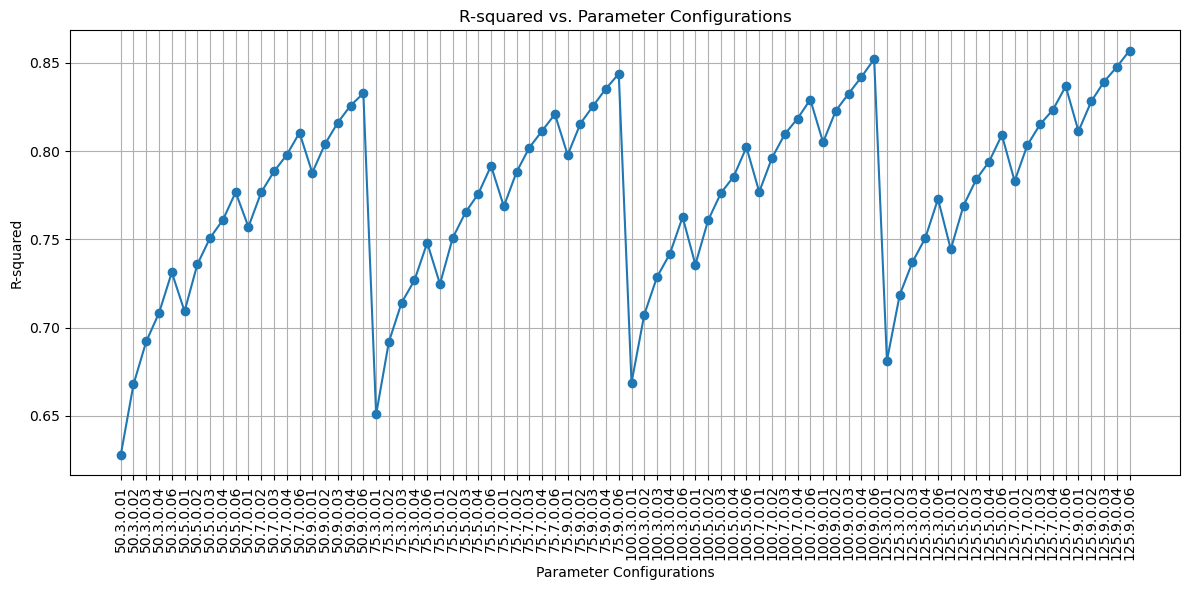

In [12]:
import matplotlib.pyplot as plt

# Data organization
test_data = {
    "50.3.0.01": 0.627747, "50.3.0.02": 0.66786, "50.3.0.03": 0.692223, "50.3.0.04": 0.708375, "50.3.0.06": 0.731325,
    "50.5.0.01": 0.709294, "50.5.0.02": 0.735867, "50.5.0.03": 0.750911, "50.5.0.04": 0.761046, "50.5.0.06": 0.776736,
    "50.7.0.01": 0.757114, "50.7.0.02": 0.776668, "50.7.0.03": 0.788516, "50.7.0.04": 0.797854, "50.7.0.06": 0.810465,
    "50.9.0.01": 0.787755, "50.9.0.02": 0.804096, "50.9.0.03": 0.816199, "50.9.0.04": 0.825843, "50.9.0.06": 0.832759,
    "75.3.0.01": 0.650855, "75.3.0.02": 0.692009, "75.3.0.03": 0.714204, "75.3.0.04": 0.726822, "75.3.0.06": 0.748096,
    "75.5.0.01": 0.724756, "75.5.0.02": 0.75088, "75.5.0.03": 0.765339, "75.5.0.04": 0.775814, "75.5.0.06": 0.791693,
    "75.7.0.01": 0.768727, "75.7.0.02": 0.788227, "75.7.0.03": 0.802058, "75.7.0.04": 0.811497, "75.7.0.06": 0.820973,
    "75.9.0.01": 0.797834, "75.9.0.02": 0.815655, "75.9.0.03": 0.825731, "75.9.0.04": 0.835458, "75.9.0.06": 0.843828,
    "100.3.0.01": 0.668762, "100.3.0.02": 0.707466, "100.3.0.03": 0.728778, "100.3.0.04": 0.741799, "100.3.0.06": 0.762698,
    "100.5.0.01": 0.735761, "100.5.0.02": 0.760861, "100.5.0.03": 0.776255, "100.5.0.04": 0.785649, "100.5.0.06": 0.802249,
    "100.7.0.01": 0.776899, "100.7.0.02": 0.796179, "100.7.0.03": 0.80962, "100.7.0.04": 0.818461, "100.7.0.06": 0.829232,
    "100.9.0.01": 0.805014, "100.9.0.02": 0.822953, "100.9.0.03": 0.832571, "100.9.0.04": 0.842008, "100.9.0.06": 0.852184,
    "125.3.0.01": 0.681308, "125.3.0.02": 0.718518, "125.3.0.03": 0.737216, "125.3.0.04": 0.750705, "125.3.0.06": 0.772908,
    "125.5.0.01": 0.744392, "125.5.0.02": 0.769184, "125.5.0.03": 0.784093, "125.5.0.04": 0.794054, "125.5.0.06": 0.809174,
    "125.7.0.01": 0.783051, "125.7.0.02": 0.803484, "125.7.0.03": 0.815239, "125.7.0.04": 0.823441, "125.7.0.06": 0.83676,
    "125.9.0.01": 0.811284, "125.9.0.02": 0.828193, "125.9.0.03": 0.839328, "125.9.0.04": 0.847697, "125.9.0.06": 0.856995
}

# Extracting data for plotting
x = list(test_data.keys())
y = list(test_data.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title('R-squared vs. Parameter Configurations')
plt.xlabel('Parameter Configurations')
plt.ylabel('R-squared')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


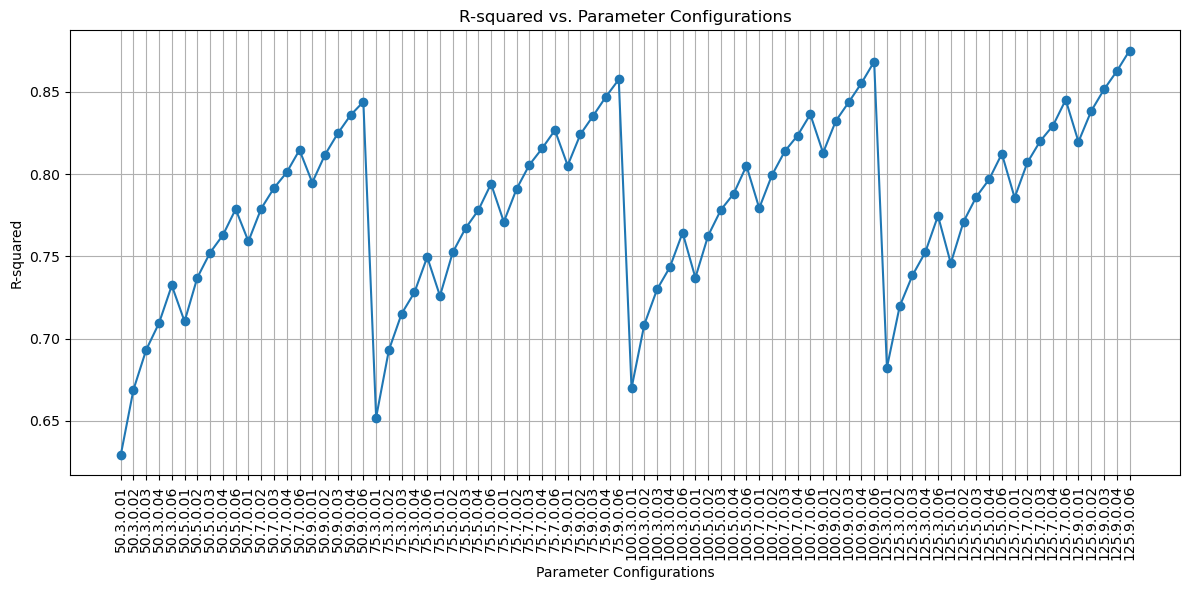

In [13]:
train_data = {
    "50.3.0.01": 0.629179, "50.3.0.02": 0.669071, "50.3.0.03": 0.693366,
    "50.3.0.04": 0.709503, "50.3.0.06": 0.732369, "50.5.0.01": 0.710489,
    "50.5.0.02": 0.737156, "50.5.0.03": 0.752339, "50.5.0.04": 0.762958,
    "50.5.0.06": 0.778748, "50.7.0.01": 0.759206, "50.7.0.02": 0.779107,
    "50.7.0.03": 0.791553, "50.7.0.04": 0.801132, "50.7.0.06": 0.814716,
    "50.9.0.01": 0.79492, "50.9.0.02": 0.811888, "50.9.0.03": 0.824807,
    "50.9.0.04": 0.835909, "50.9.0.06": 0.844015, "75.3.0.01": 0.652118,
    "75.3.0.02": 0.693115, "75.3.0.03": 0.715241, "75.3.0.04": 0.728158,
    "75.3.0.06": 0.749662, "75.5.0.01": 0.726017, "75.5.0.02": 0.752461,
    "75.5.0.03": 0.767126, "75.5.0.04": 0.77807, "75.5.0.06": 0.79414,
    "75.7.0.01": 0.771011, "75.7.0.02": 0.791064, "75.7.0.03": 0.805665,
    "75.7.0.04": 0.81569, "75.7.0.06": 0.826744, "75.9.0.01": 0.805296,
    "75.9.0.02": 0.824288, "75.9.0.03": 0.835545, "75.9.0.04": 0.847151,
    "75.9.0.06": 0.857577, "100.3.0.01": 0.669914,"100.3.0.02": 0.70858,
    "100.3.0.03": 0.73, "100.3.0.04": 0.743433, "100.3.0.06": 0.764448,
    "100.5.0.01": 0.737071, "100.5.0.02": 0.762662, "100.5.0.03": 0.778335,
    "100.5.0.04": 0.788152, "100.5.0.06": 0.805113, "100.7.0.01": 0.779369,
    "100.7.0.02": 0.799456, "100.7.0.03": 0.813915, "100.7.0.04": 0.823487,
    "100.7.0.06": 0.836384, "100.9.0.01": 0.813007, "100.9.0.02": 0.832411,
    "100.9.0.03": 0.843649, "100.9.0.04": 0.855287, "100.9.0.06": 0.868409,
    "125.3.0.01": 0.68243, "125.3.0.02": 0.719726, "125.3.0.03":0.738539,
    "125.3.0.04": 0.752498, "125.3.0.06": 0.774746, "125.5.0.01": 0.745841,
    "125.5.0.02": 0.771129, "125.5.0.03": 0.786262, "125.5.0.04": 0.796812,
    "125.5.0.06": 0.812435, "125.7.0.01": 0.785757, "125.7.0.02": 0.807125,
    "125.7.0.03": 0.82009, "125.7.0.04": 0.829503, "125.7.0.06": 0.845215,
    "125.9.0.01": 0.819714, "125.9.0.02": 0.838436, "125.9.0.03": 0.851512,
    "125.9.0.04": 0.862611, "125.9.0.06": 0.875159
}

# Extracting data for plotting
x = list(train_data.keys())
y = list(train_data.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title('R-squared vs. Parameter Configurations')
plt.xlabel('Parameter Configurations')
plt.ylabel('R-squared')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()
